In [ ]:
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import datetime as dt

from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [ ]:
neighborhoods_df = pd.read_csv('../data/neighborhood_medians.csv')
nyc_df = pd.read_csv('../data/nyc_medians.csv')
neighborhoods_df.loc[:, "Date"] = pd.to_datetime(neighborhoods_df["Date"], format='%Y-%m-%d').dt.date
nyc_df.loc[:, "Date"] = pd.to_datetime(nyc_df["Date"], format='%Y-%m-%d').dt.date

neighborhoods_df.set_index('Date', inplace=True)
nyc_df.set_index('Date', inplace=True)

neighborhoods_df = neighborhoods_df[["areaName", "Median Price", "Borough", "areaType"]]
nyc_df = nyc_df[["Median Price"]]

In [ ]:
neighborhoods_df.head()

In [ ]:
covid_start = dt.date(2020, 3, 1)
covid_end = dt.date(2021, 11, 1)

neighborhoods_df["during_covid"] = neighborhoods_df.index.to_series().between(covid_start, covid_end).astype(int)
nyc_df['during_covid'] = nyc_df.index.to_series().between(covid_start, covid_end).astype(int)

Now the data needs to be prepared for modeling by first limiting it to 2018 and up, then splitting into train/test sets.

In [ ]:
neighborhoods2018 = neighborhoods_df[neighborhoods_df.index >= dt.date(2018, 1, 1)]
nyc2018 = nyc_df[nyc_df.index >= dt.date(2018, 1, 1)]

print("Neighborhoods 2018 shape:", neighborhoods2018.shape)
print("NYC 2018 shape:", nyc2018.shape)

neighborhoods2018.head(25)

In [ ]:

boroughs2018 = neighborhoods2018.groupby(['Date', 'Borough'])['Median Price'].agg('median').reset_index()
boroughs2018 = boroughs2018.set_index("Date")
boroughs2018["during_covid"] = boroughs2018.index.to_series().between(covid_start, covid_end).astype(int)
boroughs2018.head()

In [ ]:
sns.lineplot(data=boroughs2018, x='Date', y='Median Price', hue='Borough')

In [ ]:
neighborhoods2018 = neighborhoods2018.rename(columns={'areaName': 'Neighborhood'})
boroughs2018["during_covid"] = boroughs2018.index.to_series().between(covid_start, covid_end).astype(int)
boroughs2018 = boroughs2018[boroughs2018["Borough"].notna()]
neighborhoods2018 = neighborhoods2018[neighborhoods2018["Borough"].notna()]

In [ ]:
neighborhood_names = pd.unique(neighborhoods2018['Neighborhood'])
borough_names = pd.unique(boroughs2018['Borough'])

In [ ]:
nyc2018.reset_index(inplace=True)
boroughs2018.reset_index(inplace=True)
neighborhoods2018.reset_index(inplace=True)

nyc2018['unique_id'] = "NYC_Total"
boroughs2018["unique_id"] = boroughs2018["Borough"]
neighborhoods2018["unique_id"] = neighborhoods2018["Neighborhood"]

boroughs2018["unique_id"] = boroughs2018[boroughs2018['unique_id'].notna()]['unique_id']


cols = ['unique_id', 'Date', 'Median Price', 'during_covid'] 

combined_df = pd.concat([
    nyc2018[cols], 
    boroughs2018[cols], 
    neighborhoods2018[cols]
], ignore_index=True)

combined_df = combined_df.rename(columns={'Median Price': 'y', 'Date': 'ds', 'during_covid': 'covid'})

In [ ]:
combined_df.head()

In [ ]:
hieratchy_levels = {
    "city" : "NYC_Total",
    "Borough" : borough_names,
    "Neighborhood": neighborhood_names
}

In [ ]:
neighborhood_to_borough = neighborhoods2018[['unique_id', 'Borough']].drop_duplicates().set_index('unique_id')['Borough'].to_dict()
neighborhood_to_borough

In [ ]:
combined_df['Borough'] = combined_df['unique_id'].map(neighborhood_to_borough)
combined_df['Borough'] = combined_df['Borough'].fillna('Unknown')
combined_df['Borough'] = combined_df['Borough'].astype('str')


In [101]:
df_bottom = neighborhoods2018[['Date', 'Neighborhood', 'Median Price', 'Borough', 'during_covid']]
df_bottom = df_bottom.rename({'Date': 'ds', 'Median Price': 'y'}, axis=1)

In [ ]:
from hierarchicalforecast.utils import aggregate

df_hier, S_df, tags = aggregate(df_bottom, [['Borough'], ['Borough', 'Neighborhood']])


In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import MinTrace

# 1. Train SARIMAX on all levels
sf = StatsForecast(models=[AutoARIMA(season_length=12)], freq='ME')
base_forecasts = sf.forecast(df=df_hier, h=12)

# 2. Reconcile to make them "coherent"
reconciler = HierarchicalReconciliation(reconcilers=[MinTrace(method='ols')])
reconciled_forecasts = reconciler.reconcile(Y_hat_df=base_forecasts, S=S_df, tags=tags)

In [ ]:
reconciled_forecasts.tail(20)

In [ ]:
borough_id = 'Manhattan/Chinatown'
col = 'AutoARIMA/MinTrace_method-ols'

chinatown_fcst = (
    reconciled_forecasts
    .loc[reconciled_forecasts['unique_id'] == borough_id,
         ['ds', col]]
    .rename(columns={col: 'y_hat'})
    .sort_values('ds')
)

In [ ]:
chinatown_fcst.head(10)

In [ ]:
sns.lineplot(data=chinatown_fcst, x='ds', y='y_hat')

In [ ]:
import matplotlib.pyplot as plt

def plot_forecast(forecasts, neighborhood):
    train_data = neighborhoods2018.query(f'Neighborhood == "{neighborhood}"')
    train_data = train_data.rename(columns={'Date': 'ds', 'Median Price' : 'y'})

    plt.figure(figsize=(12, 6))

    plt.plot(train_data['ds'], train_data["y"], label='Training Data', color='blue', alpha=0.7)
    plt.plot(forecasts['ds'], forecasts["y_hat"], label='Forecast', color='red', linestyle = 'dashed')


    plt.title("Backtest Performance")
    plt.xlabel("Date")
    plt.ylabel("Median Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
plot_forecast(chinatown_fcst, "Chinatown")

In [88]:
def forecast(id, reconciled_forecasts):
    col = 'AutoARIMA/MinTrace_method-ols'

    forecast = (
        reconciled_forecasts
        .loc[reconciled_forecasts['unique_id'] == id,
            ['ds', col]]
        .rename(columns={col: 'y_hat'})
        .sort_values('ds')
    )
    return forecast


In [ ]:
woodside = forecast("Queens/Woodside")
plot_forecast(woodside, "Woodside")

Now that I have the SARIMAX hierarchical model, I will test it then consider using an alternative model like Prophet.

In [96]:
df_bottom = neighborhoods2018[['Date', 'Neighborhood', 'Median Price', 'Borough', 'during_covid']]
df_bottom = df_bottom.rename({'Date': 'ds', 'Median Price': 'y'}, axis=1)
df_bottom = df_bottom[df_bottom['ds'].between(dt.date(2018, 1, 1), dt.date(2024, 12, 1))]

In [97]:
df_bottom['ds'] = pd.to_datetime(df_bottom['ds'])
train_df = df_bottom[df_bottom['ds'] < '2025-01-01']
test_df = df_bottom[df_bottom['ds'] >= '2025-01-01']

In [85]:
df_hier, S_df, tags = aggregate(train_df, [['Borough'], ['Borough', 'Neighborhood']])

sf = StatsForecast(models=[AutoARIMA(season_length=12)], freq='ME')
base_forecasts = sf.forecast(df=df_hier, h=12)

reconciler = HierarchicalReconciliation(reconcilers=[MinTrace(method='ols')])
reconciled_forecasts = reconciler.reconcile(Y_hat_df=base_forecasts, S_df=S_df, tags=tags)

In [ ]:
print(tags)

In [ ]:
for tag in tags["Borough/Neighborhood"]: 
    if "Astoria" in tag: 
        print(tag)

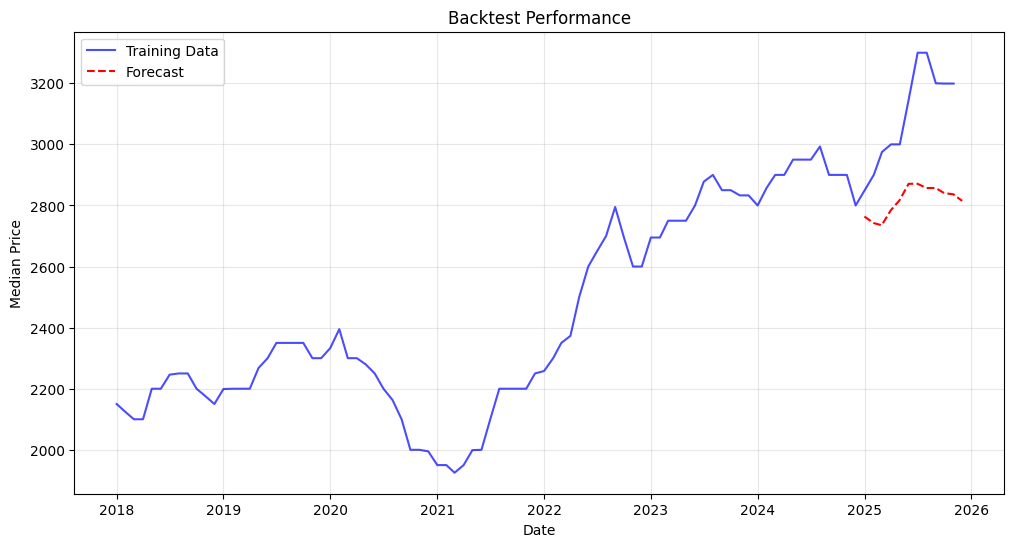

In [89]:
astoria_forecast = forecast("Queens/Astoria", reconciled_forecasts)
plot_forecast(astoria_forecast, "Astoria")

In [100]:
train_df.tail()

,ds,Neighborhood,y,Borough,during_covid
10434,2024-08-01,Woodside,3065.0,Queens,0
10435,2024-09-01,Woodside,3000.0,Queens,0
10436,2024-10-01,Woodside,2990.0,Queens,0
10437,2024-11-01,Woodside,2903.0,Queens,0
10438,2024-12-01,Woodside,2950.0,Queens,0


In [91]:


mae = mean_absolute_error(test_df['y'], astoria_forecast['y_hat'])
mse = mean_squared_error(test_df['y'], astoria_forecast['y_hat'])

print("MAE:", mae)
print("MSE:", mse)

ValueError: Found input variables with inconsistent numbers of samples: [0, 12]